# Assignment: Group Project CM1001 - Named Entity Recognition

In this assignment we will be training a NER model with the dataset given to us. It will have 3 parts, a survey, setting up the dataset and training the model and an analysis

Authors:  
Shayan Paydar Darian and 
Daniel Pazirai 


## Imports

These are the imports that will be used for the project:

In [1]:
# It is recommended to start with general import statements
from utility_functions import *
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import shap
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorForTokenClassification
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support

c:\Users\Shayan\anaconda3\envs\swedish-ner\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

This is just to load the raw data.

In [2]:
# Load the Swedish Medical NER dataset

df_1177 = pd.read_parquet("hf://datasets/community-datasets/swedish_medical_ner/1177/train-00000-of-00001.parquet")

df_lt = pd.read_parquet("hf://datasets/community-datasets/swedish_medical_ner/lt/train-00000-of-00001.parquet")

df_wiki = pd.read_parquet("hf://datasets/community-datasets/swedish_medical_ner/wiki/train-00000-of-00001.parquet")

combined_df = pd.concat([df_1177, df_lt, df_wiki], ignore_index=True)

print(df_1177.head)
print(df_lt.head)
print(df_wiki.head)

<bound method NDFrame.head of           sid                                           sentence  \
0      1177_0  Memantin ( Ebixa ) ger sällan några biverkningar.   
1      1177_1  Det är också lättare att dosera [ flytande med...   
2      1177_2  ( Förstoppning ) är ett vanligt problem hos äl...   
3      1177_3  [ Medicinen ] kan också göra att man blöder lä...   
4      1177_4  Barn har större möjligheter att samarbeta om d...   
..        ...                                                ...   
922  1177_922  Ofta kan man ha flera besvär i olika delar av ...   
923  1177_923  Vaccinationen ger inte ett fullständigt skydd ...   
924  1177_924  Vissa personer kan märka av klara förbättringa...   
925  1177_925  ( Demens ) innebär dels problem med minnet och...   
926  1177_926                                                      

                                              entities  
0    {'start': [9], 'end': [18], 'text': ['Ebixa'],...  
1    {'start': [32], 'end': [52], 'text

#### Based on the headers, the data appears to not be tokenized (which we need to do to train the model). Lets see the structure of the dataset

In [3]:
print(df_1177.info())
print(df_lt.info())
print(df_wiki.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sid       927 non-null    object
 1   sentence  927 non-null    object
 2   entities  927 non-null    object
dtypes: object(3)
memory usage: 21.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745753 entries, 0 to 745752
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sid       745753 non-null  object
 1   sentence  745753 non-null  object
 2   entities  745753 non-null  object
dtypes: object(3)
memory usage: 17.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48720 entries, 0 to 48719
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sid       48720 non-null  object
 1   sentence  48720 non-null  object
 2   entities  48720 non-null  object
dtypes: obj

## Survey of Models for Swedish Biomedical NER

| **Model**        | **Language(s)** | **Strengths**                                   | **Weaknesses**                                  | **Relevance for Biomedical NER (Swedish)**               |
|------------------|-----------------|-------------------------------------------------|-------------------------------------------------|----------------------------------------------------------|
| **KB-BERT**      | Swedish         | Native Swedish, decent at general NER tasks     | No biomedical pretraining                       | Good starting point                                      |
| **Swedish ALBERT** | Swedish       | Lightweight, faster to train                    | Lacks domain specialization                    | OK, but may miss nuance                                 |
| **mBERT**        | Multilingual    | Cross-lingual abilities                         | Not optimized for any specific language/domain | Medium                                                   |
| **XLM-RoBERTa**  | Multilingual    | Robust multilingual understanding               | Same as mBERT, no biomedical specialization    | Medium                                                   |
| **BioBERT (English)** | English    | Biomedical domain specialized                   | Needs translated data, loses Swedish nuances   | Very good if translation is perfect                      |
 
 The survey results are based on searches on HuggingFace and google scholar with keywords (Swedish NER, Biomedical NER, etc), in order to see what models there are and what models have been used before. These are the ones that we found, their strengths, weaknesses and relevance and we will discuss how we came to the conclusion of chosing the specific model.


## Approach and Motivation
In our approach, we want to use a Swedish Language-Model rather than translating the existing data into English. Although models like BioBERT offer very good performance in biomedical NER tasks, translation of clinical text can introduce errors and result in a loss of contextual information. This is particularly risky in the biomedical domain, where subtle differences in terminology can significantly impact the meaning of text. Additionally, as we are not biomedical experts, manually validating translations would be challenging.

Therefore, our approach is to fine-tune an existing Swedish model for biomedical NER, using the Swedish Medical NER dataset provided. 

The three models found on HuggingFace which were relevant were: 

bert-base-swedish-cased (v1) - A BERT trained with the same hyperparameters as first published by Google.

bert-base-swedish-cased-ner (experimental) - a BERT fine-tuned for NER using SUC 3.0.

albert-base-swedish-cased-alpha (alpha) - A first attempt at an ALBERT for Swedish.

## Our Choice
Out of of these models, we will be using the base model (bert-base-swedish-cased (v1)). Although the experimental version is fine tuned for NER, we want to train it on specifically biomedical NER. The base model will be perfect for that since it's flexible and gives us more control of fine tuning it and has less prior bias. We will also not use the Albert version since it's a first attempt at it and still in alpha.

Link for the KB bert models: https://huggingface.co/KB/bert-base-swedish-cased-ner 

Study which used KB/bert-base-swedish-cased and
bert-base-multilingual-cased: (Although not related to biomedicine) https://aclanthology.org/2024.caldpseudo-1.7.pdf 

## Setting up the Dataset and training the model:
In this part we will set up the dataset to be ready to train.

We will load the model and an autotokenizer to tokenize the dataset, which is required.

In [4]:
# We will use a pipeline as a high level helper
from transformers import pipeline

pipe = pipeline("token-classification", model="KB/bert-base-swedish-cased")# Chosen model

# Load the model

tokenizer = AutoTokenizer.from_pretrained("KB/bert-base-swedish-cased")
model = AutoModelForTokenClassification.from_pretrained("KB/bert-base-swedish-cased")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at KB/bert-base-swedish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Some weights of BertForTokenClassification were not initialized from the model checkpoint at KB/bert-base-swedish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## We save the untrained model:
(not neccesary)

In [5]:
# Save model:

# Where you want to save it
output_dir = "./models/my-swedish-ner-model-untrained"

# Save model
model.save_pretrained(output_dir)

# Save tokenizer (important!)
tokenizer.save_pretrained(output_dir)

('./models/my-swedish-ner-model-untrained\\tokenizer_config.json',
 './models/my-swedish-ner-model-untrained\\special_tokens_map.json',
 './models/my-swedish-ner-model-untrained\\vocab.txt',
 './models/my-swedish-ner-model-untrained\\added_tokens.json',
 './models/my-swedish-ner-model-untrained\\tokenizer.json')

## Combine and Tokenize the data:

The steps to combine and tokenize the data is important. We will make a function to extract unique labels the dataset has.

In [5]:
# Define a function to extract unique labels from the dataset
def prepare_labels(df):
    all_labels = set()
    for entities in df['entities']:
        if isinstance(entities, dict) and 'type' in entities:
            all_labels.update(entities['type'])
    return ['O'] + list(all_labels)  # Add 'O' for outside/no entity

Now, since we have three datasets we will combine them into one to make the training easier. We also have to prepare mapping to map the labels (map them to numerical values).

In [6]:
# Combine the datasets
combined_df = pd.concat([df_1177, df_lt, df_wiki], ignore_index=True)

# Tokenize the sentences
label_list = prepare_labels(combined_df)
label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

We will make a function to evaluate the precision, recall and f1 score. This will be important to determine how the model is functioning.

In [7]:
# Define a function to compute precision, recall, and F1-score
def compute_metrics(p):
    """Compute F1, precision, recall"""
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for i in range(len(labels)):
        for j in range(len(labels[i])):
            if labels[i][j] != -100:  # Ignore padding
                true_labels.append(labels[i][j])
                true_predictions.append(predictions[i][j])

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average="weighted")

    return {"precision": precision, "recall": recall, "f1": f1}

## We will create a function to help tokenize the dataset and align the labels so we can train the model:

In [8]:
# Define a function to tokenize text and align labels
def tokenize_and_align_labels(example, tokenizer, label_to_id):
    """Tokenize text and align labels"""
    sentence = example['sentence']
    entities = example['entities']
    
    # Tokenize sentence
    tokenized = tokenizer(sentence, truncation=True, max_length=512)
    
    # Initialize labels
    labels = [label_to_id['O']] * len(tokenized['input_ids'])
    
    # Handle entities
    if isinstance(entities, dict):
        starts = entities.get('start', [])
        ends = entities.get('end', [])
        texts = entities.get('text', [])
        types = entities.get('type', [])
        
        # Align entities with tokens
        for start, end, text, entity_type in zip(starts, ends, texts, types):
            if start is not None and end is not None:
                # Tokenize and find corresponding token indices
                word_ids = tokenizer(sentence, truncation=True, max_length=512).word_ids()
                entity_token_indices = [
                    idx for idx, word_id in enumerate(word_ids) 
                    if word_id is not None and start <= word_id < end
                ]
                
                # Assign entity label
                for idx in entity_token_indices:
                    labels[idx] = label_to_id.get(entity_type, label_to_id['O'])
    
    tokenized['labels'] = labels
    return tokenized

Finally a function to tokenize the data with the help of the previous helper function:

In [9]:
# Define a function to prepare the dataset for training
def prepare_dataset(df, tokenizer, label_to_id):
    """Prepare dataset for training"""
    # Convert to Hugging Face Dataset
    dataset = Dataset.from_pandas(df)
    
    # Tokenize and align labels
    tokenized_dataset = dataset.map(
        lambda example: tokenize_and_align_labels(example, tokenizer, label_to_id), 
        remove_columns=dataset.column_names
    )
    
    return tokenized_dataset

## We split the data and prepare it for training with the functions from before (Mapping):

In [10]:
# Split data into training and validation sets
train_df, val_df = train_test_split(combined_df, test_size=0.2, random_state=42)

# Prepare training and validation datasets
train_dataset = prepare_dataset(train_df, tokenizer, label_to_id)
val_dataset = prepare_dataset(val_df, tokenizer, label_to_id)

Map: 100%|██████████| 159080/159080 [00:25<00:00, 6342.83 examples/s]


## Show the label mapping to see that they are mapped

In [11]:
# Print label mapping
print("\nLabel Mapping:")
for label, idx in label_to_id.items():
    print(f"{label}: {idx}")


Label Mapping:
O: 0
0: 1
1: 2
2: 3


We can see that it's correctly mapped

## Initialize the model:

In [ ]:
# Initialize model with correct number of labels
model = AutoModelForTokenClassification.from_pretrained(
    "KB/bert-base-swedish-cased", 
    num_labels=len(label_list)
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at KB/bert-base-swedish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Initialize the data collator to classify the tokens:

In [12]:
# Initialize Data Collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Set the number of CPU threads (multi-threading)
torch.set_num_threads(24)  # Adjust based on your number of CPU cores

# Define the training arguments that we will throw into the trainer:

In [13]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./swedish_medical_ner_model",
    learning_rate=2e-5,
    per_device_train_batch_size=32,  # Adjusted for training speed
    per_device_eval_batch_size=32,  # Adjusted for evaluation speed
    num_train_epochs=1,  # Reduce epochs for faster training
    weight_decay=0.01,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    dataloader_num_workers=0,
    use_cpu=True  # Force using CPU
)

## Now we will initialize the trainer to train the model so we can finally train the model.

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Enables F1-score, precision, recall
)

## And FINALLY we train the model and save it so we don't have to train it again:

In [ ]:
# Train the model
print("Starting model training...")
trainer.train()

# Save the model and tokenizer
output_dir = "./models/swedish_medical_ner_model_final"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

Starting model training...


Epoch,Training Loss,Validation Loss


## Now we can evaluate the model (the training does it by itself but it takes too long to run), we load it first so we don't have to run the previous training code

In [21]:
# Evaluate the model

saved_model_path = "./models/swedish_medical_ner_model_final"

# Load the saved model and tokenizer
model = AutoModelForTokenClassification.from_pretrained(saved_model_path)
tokenizer = AutoTokenizer.from_pretrained(saved_model_path)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Enables F1-score, precision, recall
)

In [ ]:
print("Evaluating model...")
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

## Evaluate, Results, Discussion and Analysis
Now that we have trained the model we can look closer at all the results. We will look at the wrong classifications to see where the model fails:

In [ ]:
predictions = trainer.predict(val_dataset)  # Gives logits
y_pred = predictions.predictions.argmax(-1)  # Convert logits to label-ID
y_true = val_dataset["labels"]  # True labels

# Get the confidence scores:
confidence_scores = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).max(-1).values.numpy()

tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in val_dataset["input_ids"]]

print("Felklassificeringar:")
for token_list, pred_list, true_list, conf_list in zip(tokens, y_pred, y_true, confidence_scores):
    for token, pred, true, score in zip(token_list, pred_list, true_list, conf_list):
        if pred != true:  # Om modellen har gjort fel
            print(f"Token: {token}, Prediction: {id_to_label[pred]}, True: {id_to_label[true]}, Confidence: {score:.2f}")

Felklassificeringar:
Token: har, Prediction: 2, True: O, Confidence: 0.62
Token: i, Prediction: 1, True: O, Confidence: 0.63
Token: ton, Prediction: 0, True: O, Confidence: 0.79
Token: ##us, Prediction: 0, True: O, Confidence: 0.81
Token: ##reg, Prediction: 0, True: O, Confidence: 0.81
Token: (, Prediction: 0, True: O, Confidence: 0.73
Token: ., Prediction: O, True: 2, Confidence: 0.71
Token: och, Prediction: 1, True: O, Confidence: 0.84
Token: {, Prediction: O, True: 1, Confidence: 0.87
Token: }, Prediction: 1, True: O, Confidence: 0.54
Token: ), Prediction: 0, True: O, Confidence: 0.60
Token: I, Prediction: 1, True: O, Confidence: 0.63
Token: 17, Prediction: 0, True: O, Confidence: 0.63
Token: ,, Prediction: O, True: 2, Confidence: 0.87
Token: ,, Prediction: 0, True: O, Confidence: 0.75
Token: drygt, Prediction: O, True: 2, Confidence: 0.51
Token: [, Prediction: 1, True: O, Confidence: 0.51
Token: ), Prediction: 0, True: O, Confidence: 0.90
Token: (, Prediction: 0, True: O, Confidenc

## We check the top 10 lowest confidence scores

In [29]:
# Get the predictions, true labels, and confidence scores
predictions = trainer.predict(val_dataset)  # Gives logits
y_pred = predictions.predictions.argmax(-1)  # Convert logits to label-ID
y_true = val_dataset["labels"]  # True labels

# Get the confidence scores:
confidence_scores = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).max(-1).values.numpy()

# Convert the token IDs to tokens
tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in val_dataset["input_ids"]]

# Store errors with low confidence
low_confidence_errors = []

# Iterate over the dataset to identify errors and their confidence
for token_list, pred_list, true_list, conf_list in zip(tokens, y_pred, y_true, confidence_scores):
    for token, pred, true, score in zip(token_list, pred_list, true_list, conf_list):
        if pred != true and score < 0.60:  # Only store errors with low confidence
            low_confidence_errors.append((token, pred, true, score))

# Sort the low-confidence errors by score (ascending)
low_confidence_errors_sorted = sorted(low_confidence_errors, key=lambda x: x[3])

# Print the 10 tokens with the lowest confidence
print("Top 10 Tokens with Low Confidence (below 0.60):")
for token, pred, true, score in low_confidence_errors_sorted[:10]:
    print(f"Token: {token}, Prediction: {id_to_label[pred]}, True: {id_to_label[true]}, Confidence: {score:.2f}")



Top 10 Tokens with Low Confidence (below 0.60):
Token: p, Prediction: O, True: 0, Confidence: 0.34
Token: {, Prediction: O, True: 2, Confidence: 0.38
Token: (, Prediction: 0, True: O, Confidence: 0.38
Token: i, Prediction: O, True: 0, Confidence: 0.38
Token: är, Prediction: 2, True: O, Confidence: 0.38
Token: (, Prediction: 2, True: 0, Confidence: 0.40
Token: var, Prediction: 0, True: O, Confidence: 0.40
Token: k, Prediction: 1, True: 0, Confidence: 0.40
Token: tänk, Prediction: O, True: 0, Confidence: 0.41
Token: ##d, Prediction: 0, True: 2, Confidence: 0.41


We can see where the model went wrong, which we will discuss in the last part.

## Import and load the model (so you don't have to run the rest of the code):

In [14]:
from bertviz import head_view  # For attention visualization

# Load the model:
model_name = "KB/bert-base-swedish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained("./models/swedish_medical_ner_model_final", attn_implementation="eager")

## Attention weights:

In [19]:
### Extract Attention Weights
# Define a sample sentence for visualization
sample_text = "Patienten har haft ont i bröstet sedan igår kväll."
inputs = tokenizer(sample_text, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)

# Extract attention weights
attentions = outputs.attentions  # Tuple of layers
print(f"{len(attentions)} layers of attention extracted.")

# Visualize attention using bertviz
head_view(attentions, tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))

12 layers of attention extracted.


<IPython.core.display.Javascript object>

## SHAP analysis


 Sentence 1: Patienten har haft ont i bröstet sedan igår kväll.


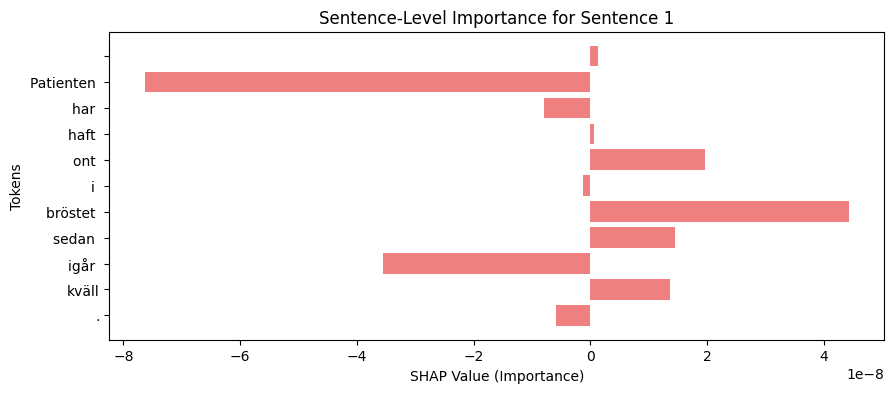


 Sentence 2: Kunden klagade på huvudvärk och illamående


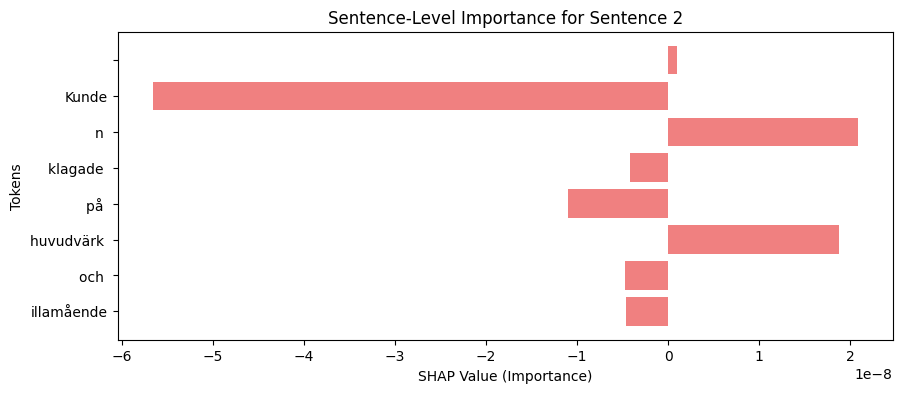


 Sentence 3: Han klagar på smärtor i ryggen och stelhet efter att ha suttit länge.


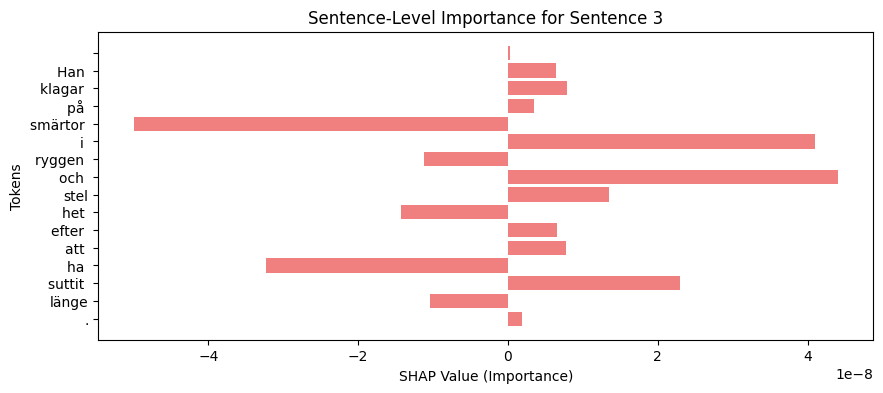

In [ ]:
def model_wrapper(texts):
    
    # Convert numpy array to list if needed
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()

    inputs = tokenizer(texts, return_tensors="pt", truncation=True, max_length=512, padding=True)

    with torch.no_grad():
        logits = model(**inputs).logits  # Shape: (batch_size, sequence_length, num_classes)
        
        # Collapse token-level logits to sentence-level (max over sequence)
        sentence_logits = logits.max(dim=1).values  # Shape: (batch_size, num_classes)
        
        # Convert logits to probabilities
        probs = F.softmax(sentence_logits, dim=-1)  # Shape: (batch_size, num_classes)
        
    # Return sentence-level probabilities (for multi-class classification)
    return probs.numpy()  # Shape: (batch_size, num_classes)

def shap_analysis(sentences):
    
    # Ensure sentences is a list
    if isinstance(sentences, str):
        sentences = [sentences]
    
    # Add a masker for text input
    explainer = shap.Explainer(model_wrapper, shap.maskers.Text(tokenizer))  
    shap_values = explainer(sentences)  # Explain multiple sentences

    for i, sentence in enumerate(sentences):
        print(f"\n Sentence {i+1}: {sentence}")
        shap.plots.text(shap_values[i])  # Show SHAP visualization per sentence

        # Extract SHAP values (sentence-level)
        sentence_importance = shap_values.values[i].sum(axis=-1)  # Sum across all classes for sentence-level importance
        tokens = shap_values.data[i]  # Extract tokens

        # Plot sentence-level importance
        plt.figure(figsize=(10, 4))
        plt.barh(tokens, sentence_importance, color="lightcoral")
        plt.xlabel("SHAP Value (Importance)")
        plt.ylabel("Tokens")
        plt.title(f"Sentence-Level Importance for Sentence {i+1}")
        plt.gca().invert_yaxis()  
        plt.show()

test_sentences = [
    "Patienten har haft ont i bröstet sedan igår kväll.",
    "Kunden klagade på huvudvärk och illamående",
    "Han klagar på smärtor i ryggen och stelhet efter att ha suttit länge.",
]

shap_analysis(test_sentences)


# Results and Discussion:

### Epoch 1 Results:

- **Training Loss**: 0.018400
- **Validation Loss**: 0.015236
- **Precision**: 0.992901
- **Recall**: 0.992872
- **F1 Score**: 0.992884

The precision score, the recall and the f1 score are all very good. It could probably go up with 2 or 3 epochs instead of 1, but the accuracy of the F1 score, Recall and Precision are all good enough, (over 99%).

---

## Analysis of Wrong Classifications:

### Top 10 Tokens with Low Confidence (below 0.60):

| Token  | Prediction | True | Confidence |
|--------|------------|------|------------|
| p      | O          | 0    | 0.34       |
| {      | O          | 2    | 0.38       |
| (      | 0          | O    | 0.38       |
| i      | O          | 0    | 0.38       |
| är     | 2          | O    | 0.38       |
| (      | 2          | 0    | 0.40       |
| var    | 0          | O    | 0.40       |
| k      | 1          | 0    | 0.40       |
| tänk   | O          | 0    | 0.41       |
| ##d    | 0          | 2    | 0.41       |

We can see that (, ), and some common words such as var, är, and i have low confidence. Also p was probably part of a multi-token word which the model probably struggled to classify.

The low confidence in these tokens could stem from a combination of punctuation marks, common verbs, subword tokens, and single characters.

The model struggled with distinguishing between entities and non-entity tokens in contexts where these tokens were part of a larger phrase or where punctuation or subword tokens caused confusion.

Tokens like i and tänk are common words that might not typically be part of a named entity, but the model might have misclassified them based on their proximity to relevant entities.

Subword tokens (e.g., ##d) are common in models like BERT, where tokens are broken down into smaller pieces. These might be harder for the model to classify correctly when it is unsure of the whole word context.

## Analysis of SHAP:

**Let's look at the first example and see why the models focus is on those tokens:**

Sentence 1: "Patienten har haft ont i bröstet sedan igår kväll."

**Top 4 Positive importance tokens:** "Ont", "Bröstet", "Sedan", "Kväll".

As a human, without focusing on the other words, you can kind of figure out what it's about. You don't need words like "Patienten" or "i" or "haft". "Ont" is the symptom, "Bröstet" is the location" and "Sedan", "Kväll" communicates time. 

**Let's look at example 2.**

Sentence 2: "Kunden klagade på huvudvärk och illamående."

**Top 2** Positive importance tokens: "N", "Huvudvärk". N comes out due to tokenization. Without the fragmentation it would be Kunden. In this example we can also see that the main symptom is "huvudvärk". We can draw information out of that, even not focusing on words like "klagade" and "på"

**Example 3.**

Sentence 3: "Han klagar på smärtor i ryggen och stelhet efter att ha suttit länge."

**Top 4:** "I", "Och", "Stel", "Suttit"

"I" relates to the location of the pain. Combined with "Ryggen" it messages the location. "Och" is important since it connects two symptoms. Even though it's not technically important by itself. The context it gives is good since it gives the symptoms (Stel), location (I, Ryggen), and why (Suttit). 

---

## Analysis of Attention Weights:

The attention mechanism helps the model focus on relevant tokens in a sentence. By visualizing attention weights, we can better understand how the model processes context and identifies relationships between tokens. We can see all the 12 layers and see how they connect. We can see that it's relating all the words to the other words in the sentence.

---

## Conclusion:

Based on the results from training for one epoch, we can conclude the following:

- **Model Performance**: The model performed well overall, achieving high precision, recall, and F1 score, all above 0.99, good ability to correctly identify entities. The model could likely benefit from further training with additional epochs, but currently it's doing well.

- **Analysis of Misclassifications**: The model showed some uncertainty in classifying tokens, particularly punctuation marks, subword tokens, and common function words (e.g., "i", "är", "var"). These tokens likely caused confusion since they are ambiguous. Further fine-tuning, or improved handling of subword tokenization, might help the model handle these edge cases more effectively.

- **SHAP Analysis**: The SHAP analysis revealed that the model focuses on key symptom and location words (e.g., "Ont", "Bröstet") and context words (e.g., "Sedan", "Kväll"). This indicates that the model is effectively leveraging context to make its predictions. However, certain words like "Kunden" were fragmented (tokenized as "N"), which impacted the interpretability of the SHAP values.

Overall, while the model is performing well, there are areas for improvement, such as handling subword tokens and function words more effectively. Further analysis and model refinement, including additional epochs and better token handling, should help address these issues and improve accuracy.


